In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
from pathlib import Path

# Add src to path
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dotenv import load_dotenv
load_dotenv()

from src.data.preprocessing import load_processed_ed_data, NUMERIC_COLS

In [2]:
df = load_processed_ed_data()
cols = df.columns
print(cols)

Index(['stay_id', 'subject_id_stay', 'hadm_id', 'intime', 'outtime', 'gender',
       'race', 'arrival_transport', 'disposition', 'subject_id', 'temperature',
       'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity',
       'chiefcomplaint'],
      dtype='str')


In [3]:
row = df.iloc[0]
print(row)

stay_id                                    33258284
subject_id_stay                            10000032
hadm_id                                  22595853.0
intime                          2180-05-06 19:17:00
outtime                         2180-05-06 23:30:00
gender                                            F
race                                          WHITE
arrival_transport                         AMBULANCE
disposition                                ADMITTED
subject_id                                 10000032
temperature                                    98.4
heartrate                                      70.0
resprate                                       16.0
o2sat                                          97.0
sbp                                           106.0
dbp                                            63.0
pain                                            0.0
acuity                                          3.0
chiefcomplaint       Abd pain, Abdominal distention
Name: 0, dty

In [4]:
for i in range(10):
    row = df.iloc[i]
    time = pd.to_datetime(row.outtime) - pd.to_datetime(row.intime)
    print(time)

0 days 04:13:00
0 days 05:37:00
0 days 04:46:00
0 days 13:30:00
0 days 08:06:00
0 days 06:44:00
0 days 21:35:00
0 days 16:46:00
0 days 01:39:00
0 days 04:48:00


In [5]:
print(NUMERIC_COLS)
print(cols)
print('\n')
for col in cols:
    if col not in NUMERIC_COLS: print(col)

['temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity']
Index(['stay_id', 'subject_id_stay', 'hadm_id', 'intime', 'outtime', 'gender',
       'race', 'arrival_transport', 'disposition', 'subject_id', 'temperature',
       'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity',
       'chiefcomplaint'],
      dtype='str')


stay_id
subject_id_stay
hadm_id
intime
outtime
gender
race
arrival_transport
disposition
subject_id
chiefcomplaint


In [6]:
# Check for null values
print("Null values in intime:", df['intime'].isna().sum())
print("Null values in outtime:", df['outtime'].isna().sum())

# Check for invalid time relationships (outtime before intime)
df['intime_dt'] = pd.to_datetime(df['intime'])
df['outtime_dt'] = pd.to_datetime(df['outtime'])
invalid_times = df['outtime_dt'] < df['intime_dt']
print(f"Rows where outtime < intime: {invalid_times.sum()}")
same_times = df['outtime_dt'] == df['intime_dt']
print(f"Rows where outtime == intime: {same_times.sum()}")

# Check for extreme values
print(f"\nMin intime: {df['intime_dt'].min()}")
print(f"Max intime: {df['intime_dt'].max()}")
print(f"Min outtime: {df['outtime_dt'].min()}")
print(f"Max outtime: {df['outtime_dt'].max()}")

Null values in intime: 0
Null values in outtime: 0
Rows where outtime < intime: 6
Rows where outtime == intime: 53

Min intime: 2110-01-11 01:45:00
Max intime: 2212-04-05 23:23:00
Min outtime: 2110-01-11 07:04:00
Max outtime: 2212-04-06 14:20:00


In [7]:
df['stay_len'] = (pd.to_datetime(df['outtime']) - pd.to_datetime(df['intime'])).dt.total_seconds() / 3600.0

# Remove rows with negative or zero stay lengths
n_before = len(df)
df = df[df['stay_len'] > 0]
n_after = len(df)
print(f"Removed {n_before - n_after} rows with non-positive stay lengths")
print(f"Remaining rows: {n_after}")
print(f"\nStay length stats (hours):")
print(df['stay_len'].describe())

# Drop temporary datetime columns — no longer needed and waste memory
df.drop(columns=['intime_dt', 'outtime_dt'], inplace=True)

# --- Set N_SAMPLE = None to train on the full dataset ---
N_SAMPLE = None
if N_SAMPLE is not None:
    df = df.sample(n=N_SAMPLE, random_state=42)
    print(f"\nSubsampled to {N_SAMPLE} rows for fast testing.")

Removed 59 rows with non-positive stay lengths
Remaining rows: 425028

Stay length stats (hours):
count    425028.000000
mean          7.159524
std           6.627396
min           0.016667
25%           3.533333
50%           5.466667
75%           8.316667
max         493.069444
Name: stay_len, dtype: float64


In [8]:
id_cols    = ['stay_id', 'subject_id_stay', 'hadm_id', 'subject_id']
cat_cols   = ['gender', 'race', 'arrival_transport']  # disposition excluded: it's end-of-visit data, not available at triage
time_cols  = ['intime']   # will be encoded as cyclical features
target_col = 'stay_len'
# outtime leaks the target; chiefcomplaint is unstructured free text (excluded)

print("Categorical columns:", cat_cols)
print("Numeric columns:    ", NUMERIC_COLS)
print("Time columns:       ", time_cols)
print("Target:             ", target_col)

Categorical columns: ['gender', 'race', 'arrival_transport']
Numeric columns:     ['temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity']
Time columns:        ['intime']
Target:              stay_len


In [9]:
import gc

# --- Cyclical time features from intime ---
# Encode hour-of-day, day-of-week, and month as sin/cos pairs so the model
# can understand that 23:00 and 00:00 are close in time.
intime = pd.to_datetime(df['intime'])
hour  = intime.dt.hour + intime.dt.minute / 60.0
dow   = intime.dt.dayofweek   # 0=Monday … 6=Sunday
month = intime.dt.month       # 1–12

time_features = pd.DataFrame({
    'hour_sin':  np.sin(2 * np.pi * hour / 24),
    'hour_cos':  np.cos(2 * np.pi * hour / 24),
    'dow_sin':   np.sin(2 * np.pi * dow / 7),
    'dow_cos':   np.cos(2 * np.pi * dow / 7),
    'month_sin': np.sin(2 * np.pi * (month - 1) / 12),
    'month_cos': np.cos(2 * np.pi * (month - 1) / 12),
}, index=df.index)

# --- One-hot encode categorical columns ---
cat_encoded = pd.get_dummies(df[cat_cols], prefix=cat_cols, drop_first=False, dtype=float)

# --- Numeric features: impute missing values with each column's median ---
numeric_df = df[NUMERIC_COLS].copy().apply(lambda col: col.fillna(col.median()))

# --- Combine into final feature matrix ---
X = pd.concat([time_features, cat_encoded, numeric_df], axis=1)
y = df[target_col].values

# Free intermediates and the source DataFrame — X and y are all we need going forward
del time_features, cat_encoded, numeric_df, df
gc.collect()

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\nFeatures ({len(X.columns)}):")
print(list(X.columns))

X shape: (425028, 54)
y shape: (425028,)

Features (54):
['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'gender_F', 'gender_M', 'race_AMERICAN INDIAN/ALASKA NATIVE', 'race_ASIAN', 'race_ASIAN - ASIAN INDIAN', 'race_ASIAN - CHINESE', 'race_ASIAN - KOREAN', 'race_ASIAN - SOUTH EAST ASIAN', 'race_BLACK/AFRICAN', 'race_BLACK/AFRICAN AMERICAN', 'race_BLACK/CAPE VERDEAN', 'race_BLACK/CARIBBEAN ISLAND', 'race_HISPANIC OR LATINO', 'race_HISPANIC/LATINO - CENTRAL AMERICAN', 'race_HISPANIC/LATINO - COLUMBIAN', 'race_HISPANIC/LATINO - CUBAN', 'race_HISPANIC/LATINO - DOMINICAN', 'race_HISPANIC/LATINO - GUATEMALAN', 'race_HISPANIC/LATINO - HONDURAN', 'race_HISPANIC/LATINO - MEXICAN', 'race_HISPANIC/LATINO - PUERTO RICAN', 'race_HISPANIC/LATINO - SALVADORAN', 'race_MULTIPLE RACE/ETHNICITY', 'race_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'race_OTHER', 'race_PATIENT DECLINED TO ANSWER', 'race_PORTUGUESE', 'race_SOUTH AMERICAN', 'race_UNABLE TO OBTAIN', 'race_UNKNOWN', 'rac

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
torch.manual_seed(42)

# Save column names before dropping X (needed for XGBoost feature importance later)
feature_names = list(X.columns)

X_arr = X.values.astype(np.float32)
y_arr = y.astype(np.float32)

# X is no longer needed — the numpy array is all we work with from here
del X
gc.collect()

X_train, X_val, y_train, y_val = train_test_split(
    X_arr, y_arr, test_size=0.2, random_state=42
)

# Fit scaler on training data only to avoid data leakage
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)

print(f"Train size: {X_train.shape}, Val size: {X_val.shape}")

Using device: cuda
Train size: (340022, 54), Val size: (85006, 54)


In [11]:
class EDDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

BATCH_SIZE    = 512
train_dataset = EDDataset(X_train, y_train)
val_dataset   = EDDataset(X_val,   y_val)
train_loader  = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader    = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

Train batches: 665, Val batches: 167


In [12]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, dropout=0.3):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers += [nn.Linear(prev_dim, h), nn.ReLU(), nn.Dropout(dropout)]
            prev_dim = h
        layers.append(nn.Linear(prev_dim, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [13]:
input_dim = X_train.shape[1]
model     = MLP(input_dim, hidden_dims=[256, 128, 64], dropout=0.3).to(device)
criterion = nn.HuberLoss(delta=5.0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=3, factor=0.5, min_lr=1e-5
)

print(model)
print(f"\nTrainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

MLP(
  (net): Sequential(
    (0): Linear(in_features=54, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
)

Trainable parameters: 55,297


Epoch   1/30 | Train: 10.739 | Val: 9.747 | LR: 1.00e-03
Epoch   2/30 | Train: 10.200 | Val: 9.715 | LR: 1.00e-03
Epoch   3/30 | Train: 10.128 | Val: 9.815 | LR: 1.00e-03
Epoch   4/30 | Train: 10.089 | Val: 9.696 | LR: 1.00e-03
Epoch   5/30 | Train: 10.044 | Val: 9.714 | LR: 1.00e-03
Epoch   6/30 | Train: 10.011 | Val: 9.690 | LR: 1.00e-03
Epoch   7/30 | Train: 9.987 | Val: 9.706 | LR: 1.00e-03
Epoch   8/30 | Train: 9.959 | Val: 9.689 | LR: 1.00e-03
Epoch   9/30 | Train: 9.941 | Val: 9.694 | LR: 1.00e-03
Epoch  10/30 | Train: 9.932 | Val: 9.744 | LR: 1.00e-03
Epoch  11/30 | Train: 9.920 | Val: 9.674 | LR: 1.00e-03
Epoch  12/30 | Train: 9.909 | Val: 9.663 | LR: 1.00e-03
Epoch  13/30 | Train: 9.892 | Val: 9.683 | LR: 1.00e-03
Epoch  14/30 | Train: 9.883 | Val: 9.667 | LR: 1.00e-03
Epoch  15/30 | Train: 9.877 | Val: 9.661 | LR: 1.00e-03
Epoch  16/30 | Train: 9.867 | Val: 9.660 | LR: 1.00e-03
Epoch  17/30 | Train: 9.861 | Val: 9.669 | LR: 1.00e-03
Epoch  18/30 | Train: 9.855 | Val: 9.657 |

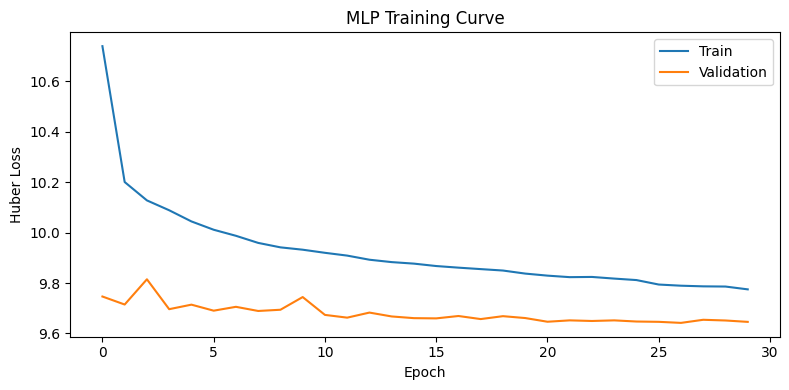

In [14]:
EPOCHS = 30
train_losses, val_losses = [], []

X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_t  = torch.tensor(y_val, dtype=torch.float32).to(device)

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        pred = model(X_batch).squeeze()
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * len(X_batch)

    model.eval()
    with torch.no_grad():
        val_loss = criterion(model(X_val_t).squeeze(), y_val_t).item()

    train_losses.append(running_loss / len(train_dataset))
    val_losses.append(val_loss)
    scheduler.step(val_loss)

    lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1:3d}/{EPOCHS} | Train: {train_losses[-1]:.3f} | Val: {val_loss:.3f} | LR: {lr:.2e}")

plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Huber Loss')
plt.title('MLP Training Curve')
plt.legend()
plt.tight_layout()

Validation MAE:              3.501 hours
Validation RMSE:             6.350 hours
Baseline MAE (predict mean): 4.022 hours
Baseline RMSE (predict mean): 6.490 hours


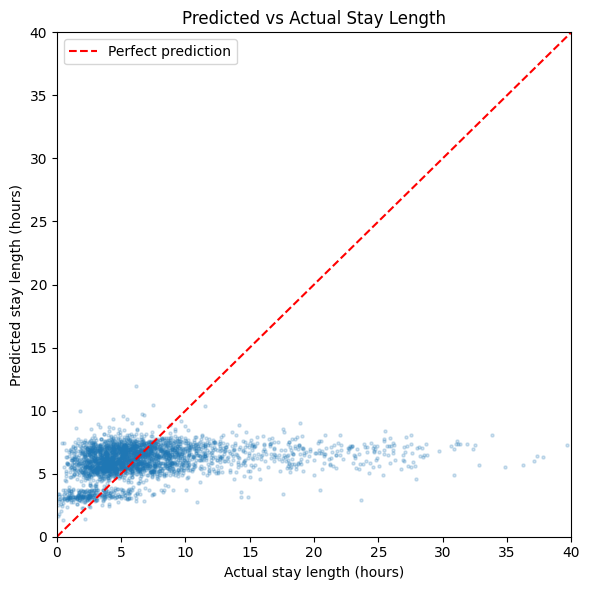

In [15]:
model.eval()
with torch.no_grad():
    val_pred = model(X_val_t).squeeze().cpu().numpy()

mae  = np.mean(np.abs(val_pred - y_val))
rmse = np.sqrt(np.mean((val_pred - y_val) ** 2))
baseline_mae = np.mean(np.abs(y_train.mean() - y_val))
baseline_rmse = np.sqrt(np.mean((y_train.mean() - y_val) ** 2))

print(f"Validation MAE:              {mae:.3f} hours")
print(f"Validation RMSE:             {rmse:.3f} hours")
print(f"Baseline MAE (predict mean): {baseline_mae:.3f} hours")
print(f"Baseline RMSE (predict mean): {baseline_rmse:.3f} hours")

plt.figure(figsize=(6, 6))
plt.scatter(y_val[:3000], val_pred[:3000], alpha=0.2, s=5)
plt.plot([0, 100], [0, 100], 'r--', label='Perfect prediction')
plt.xlabel('Actual stay length (hours)')
plt.ylabel('Predicted stay length (hours)')
plt.title('Predicted vs Actual Stay Length')
plt.xlim(0, 40)
plt.ylim(0, 40)
plt.legend()
plt.tight_layout()

In [16]:
from xgboost import XGBRegressor

# Tree-based models are scale-invariant — use the original unscaled splits
X_train_raw, X_val_raw, y_train_raw, y_val_raw = train_test_split(
    X_arr, y_arr, test_size=0.2, random_state=42
)

xgb_model = XGBRegressor(
    n_estimators=5000,
    max_depth=8,
    learning_rate=0.02,
    subsample=0.7,
    colsample_bytree=0.7,
    min_child_weight=3,
    objective='reg:pseudohubererror',
    tree_method='hist',
    device='cuda',
    early_stopping_rounds=20,
    n_jobs=4,
    random_state=42,
    verbosity=0,
)

xgb_model.fit(
    X_train_raw, y_train_raw,
    eval_set=[(X_val_raw, y_val_raw)],
    verbose=20,
)

[0]	validation_0-mphe:17.66670
[20]	validation_0-mphe:7.02836
[40]	validation_0-mphe:4.75956
[60]	validation_0-mphe:4.26170
[80]	validation_0-mphe:4.03572
[100]	validation_0-mphe:3.83906
[120]	validation_0-mphe:3.72434
[140]	validation_0-mphe:3.62625
[160]	validation_0-mphe:3.54961
[180]	validation_0-mphe:3.48855
[200]	validation_0-mphe:3.42857
[220]	validation_0-mphe:3.38160
[240]	validation_0-mphe:3.33757
[260]	validation_0-mphe:3.30923
[280]	validation_0-mphe:3.28872
[300]	validation_0-mphe:3.26738
[320]	validation_0-mphe:3.25708
[340]	validation_0-mphe:3.25055
[360]	validation_0-mphe:3.24386
[380]	validation_0-mphe:3.23453
[400]	validation_0-mphe:3.22684
[420]	validation_0-mphe:3.22220
[440]	validation_0-mphe:3.21923
[460]	validation_0-mphe:3.21574
[480]	validation_0-mphe:3.20824
[500]	validation_0-mphe:3.20059
[520]	validation_0-mphe:3.19674
[540]	validation_0-mphe:3.19202
[560]	validation_0-mphe:3.19062
[580]	validation_0-mphe:3.18767
[600]	validation_0-mphe:3.18359
[620]	validat

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:pseudohubererror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.7
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",'cuda'
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",20
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabe

XGBoost Validation MAE:  3.715 hours
XGBoost Validation RMSE: 6.600 hours


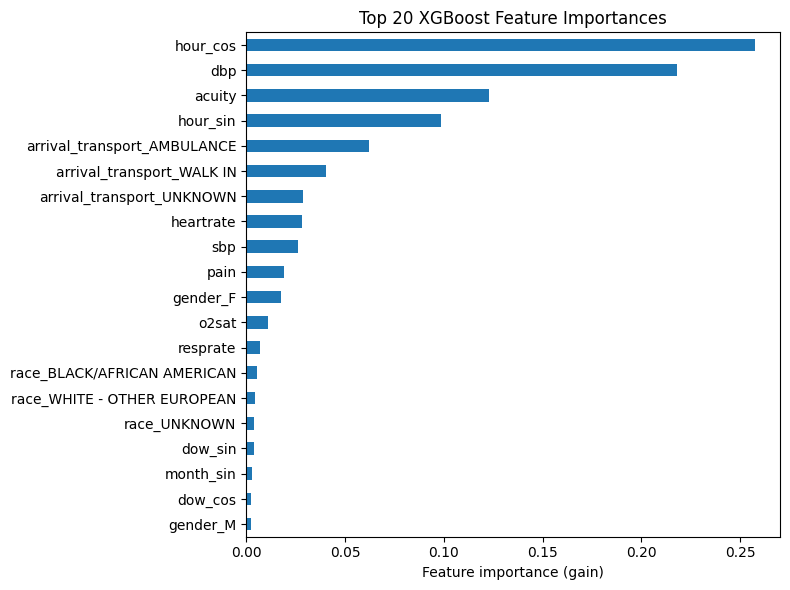

In [17]:
xgb_pred = xgb_model.predict(X_val_raw)
xgb_mae  = np.mean(np.abs(xgb_pred - y_val_raw))
xgb_rmse = np.sqrt(np.mean((xgb_pred - y_val_raw) ** 2))

print(f"XGBoost Validation MAE:  {xgb_mae:.3f} hours")
print(f"XGBoost Validation RMSE: {xgb_rmse:.3f} hours")

feat_imp = pd.Series(xgb_model.feature_importances_, index=feature_names).sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(8, 6))
feat_imp.head(20).plot(kind='barh', ax=ax)
ax.invert_yaxis()
ax.set_xlabel('Feature importance (gain)')
ax.set_title('Top 20 XGBoost Feature Importances')
plt.tight_layout()

In [24]:
print(f"MLP Validation MAE:           {mae:.3f} hours")
print(f"XGBoost Validation MAE:       {xgb_mae:.3f} hours")
print(f"Baseline MAE (predict mean):  {baseline_mae:.3f} hours")
print("")
print(f"MLP Validation RMSE:          {rmse:.3f} hours")
print(f"XGBoost Validation RMSE:      {xgb_rmse:.3f} hours")
print(f"Baseline RMSE (predict mean): {baseline_rmse:.3f} hours")

MLP Validation MAE:           3.501 hours
XGBoost Validation MAE:       3.715 hours
Baseline MAE (predict mean):  4.022 hours

MLP Validation RMSE:          6.350 hours
XGBoost Validation RMSE:      6.600 hours
Baseline RMSE (predict mean): 6.490 hours
